In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
!conda install -c conda-forge shap --yes
!pip install smdebug --upgrade

Channels:
 - conda-forge
Platform: linux-64
doneecting package metadata (repodata.json): - 


In [3]:
import re
import s3fs
import time
import boto3
import pandas as pd
import numpy as np

from itertools import islice
import matplotlib.pyplot as plt

import sagemaker
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
from sagemaker.debugger import DebuggerHookConfig,CollectionConfig
from sagemaker.debugger import rule_configs, Rule
from smdebug.trials import create_trial
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
[2025-04-19 23:27:56.339 default:4330 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [4]:
# S2 Bucket
default_bucket = "customer-churn-sm-pipeline-bd2"

In [5]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_region_name

In [6]:
def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    ## Convert to datetime columns
    df["firstorder"]=pd.to_datetime(df["firstorder"],errors='coerce')
    df["lastorder"] = pd.to_datetime(df["lastorder"],errors='coerce')
    ## Drop Rows with null values
    df = df.dropna()
    ## Create Column which gives the days between the last order and the first order
    df["first_last_days_diff"] = (df['lastorder']-df['firstorder']).dt.days
    ## Create Column which gives the days between when the customer record was created and the first order
    df['created'] = pd.to_datetime(df['created'])
    df['created_first_days_diff']=(df['created']-df['firstorder']).dt.days
    ## Drop Columns
    df.drop(['custid','created','firstorder','lastorder'],axis=1,inplace=True)
    ## Apply one hot encoding on favday and city columns
    df = pd.get_dummies(df,prefix=['favday','city'],columns=['favday','city'])
    return df

In [9]:
def preprocess_data(file_path):
    # Assuming the function reads an Excel file from S3 using pandas
    return pd.read_excel(file_path)

storedata = preprocess_data(f"s3://customer-churn-sm-pipeline-bd2/storedata_total.xlsx")

/opt/conda/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [10]:
storedata.head()

,custid,retained,created,firstorder,lastorder,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,favday,city
0,6H6T6N,0,2012-09-28,2013-08-11 00:00:00,2013-08-11 00:00:00,29,100.000000,3.448276,14.52,0.000000,0,0,0,Monday,DEL
1,APCENR,1,2010-12-19,2011-04-01 00:00:00,2014-01-19 00:00:00,95,92.631579,10.526316,83.69,0.181641,1,1,1,Friday,DEL
2,7UP6MS,0,2010-10-03,2010-12-01 00:00:00,2011-07-06 00:00:00,0,0.000000,0.000000,33.58,0.059908,0,0,0,Wednesday,DEL
3,7ZEW8G,0,2010-10-22,2011-03-28 00:00:00,2011-03-28 00:00:00,0,0.000000,0.000000,54.96,0.000000,0,0,0,Thursday,BOM
4,8V726M,1,2010-11-27,2010-11-29 00:00:00,2013-01-28 00:00:00,30,90.000000,13.333333,111.91,0.008850,0,0,0,Monday,BOM


In [17]:
# # Read the Excel file into a DataFrame
# storedata = pd.read_excel("storedata_total.xlsx")

# # Preview the data
# storedata.head()

In [11]:
# Split Train, Test and Validation Datasets
def split_datasets(df):
    y=df.pop("retained")
    X_pre = df
    y_pre = y.to_numpy().reshape(len(y),1)
    feature_names = list(X_pre.columns)
    X= np.concatenate((y_pre,X_pre),axis=1)
    np.random.shuffle(X)
    train,validation,test=np.split(X,[int(.7*len(X)),int(.85*len(X))])
    return feature_names,train,validation,test

In [12]:
feature_names,train,validation,test = split_datasets(storedata)

In [13]:
pd.DataFrame(train).to_csv(f"s3://{default_bucket}/train/train.csv",header=False,index=False)
pd.DataFrame(validation).to_csv(f"s3://{default_bucket}/validation/validation.csv",header=False,index=False)
pd.DataFrame(test).to_csv(f"s3://{default_bucket}/test/test.csv",header=False,index=False)

In [14]:
# Hyperparameter Tuning HPO
s3_input_train = TrainingInput(
    s3_data=f"s3://{default_bucket}/train/",content_type="csv")
s3_input_validation = TrainingInput(
    s3_data=f"s3://{default_bucket}/validation/",content_type="csv")

In [15]:
fixed_hyperparameters = {
    "eval_metric":"auc",
    "objective":"binary:logistic",
    "num_round":"100",
    "rate_drop":"0.3",
    "tweedie_variance_power":"1.4"
}

In [16]:
region = "us-east-2"
sagemaker_session = sagemaker.Session()

# Ensure image URI matches the specified region
container = sagemaker.image_uris.retrieve("xgboost", region=region, version="0.90-2")

estimator = sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    hyperparameters=fixed_hyperparameters,
    output_path=f"s3://{sagemaker_session.default_bucket()}/output",
    sagemaker_session=sagemaker_session
)

[04/19/25 23:34:20] INFO     Defaulting to only available Python version: py3                     ]8;id=316263;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=332109;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#610\610]8;;\

[04/19/25 23:34:21] INFO     Defaulting to only supported image scope: cpu.                       ]8;id=518951;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=65457;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#534\534]8;;\

In [17]:
hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "min_child_weight": ContinuousParameter(1, 10),
    "alpha": ContinuousParameter(0, 2),
    "max_depth": IntegerParameter(1, 10),
}

In [18]:
objective_metric_name = "validation:auc"

In [19]:
tuner = HyperparameterTuner(
    estimator,objective_metric_name,hyperparameter_ranges,max_jobs=10,max_parallel_jobs=2)

In [20]:
tuner.fit({
    "train":s3_input_train,
    "validation":s3_input_validation
    },include_cls_metadata=False)

[04/19/25 23:34:29] WARNING  No finished training job found associated with this estimator.       ]8;id=21481;file:///opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=181200;file:///opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    WARNING  No finished training job found associated with this estimator.       ]8;id=596060;file:///opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=199094;file:///opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    INFO     Creating hyperparameter tuning job with name:                          ]8;id=118345;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=138765;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#3383\3383]8;;\
                             sagemaker-xgboost-250419-2334                                                         

...........................................................................!


In [21]:
tuning_job_result = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)

In [22]:
job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" %job_count)

10 training jobs have completed


In [23]:
from pprint import pprint

if tuning_job_result.get("BestTrainingJob",None):
    print("Best Model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

Best Model found so far:
{'CreationTime': datetime.datetime(2025, 4, 19, 23, 40, 9, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:auc',
                                                 'Value': 0.9873859882354736},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2025, 4, 19, 23, 40, 46, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-2:203918849777:training-job/sagemaker-xgboost-250419-2334-010-59251f91',
 'TrainingJobName': 'sagemaker-xgboost-250419-2334-010-59251f91',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2025, 4, 19, 23, 40, 13, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '0.7764702313115284',
                          'eta': '0.06881190794598135',
                          'max_depth': '7',
                          'min_child_weight': '9.293411786821402'}}


In [24]:
best_hyperparameters = tuning_job_result["BestTrainingJob"]["TunedHyperParameters"]

In [25]:
best_hyperparameters

{'alpha': '0.7764702313115284',
 'eta': '0.06881190794598135',
 'max_depth': '7',
 'min_child_weight': '9.293411786821402'}

In [26]:
# XGBoost Model with SageMaker Debugger
hyperparameters = {**fixed_hyperparameters,**best_hyperparameters}
save_interval = 5
base_job_name = "demo-smdebug-xgboost-churn-classification"

In [27]:
container = sagemaker.image_uris.retrieve("xgboost",region,"0.90-2")

[04/19/25 23:43:31] INFO     Defaulting to only available Python version: py3                     ]8;id=535707;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=23942;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#610\610]8;;\

                    INFO     Defaulting to only supported image scope: cpu.                       ]8;id=708723;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=449796;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#534\534]8;;\

In [29]:
estimator = sagemaker.estimator.Estimator(
    container,
    role,
    base_job_name=base_job_name,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(default_bucket),
    sagemaker_session=sagemaker_session,
    hyperparameters=hyperparameters,
    max_run=1800,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path=f"s3://{default_bucket}/debugger/",  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "5"
                }),
            CollectionConfig(
                name="feature_importance", parameters={"save_interval": "5"}
            ),
            CollectionConfig(name="full_shap", parameters={"save_interval": "5"}),
            CollectionConfig(name="average_shap", parameters={"save_interval": "5"}),
        ]
    ),
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": "10",
            },
        ),
    ]
)

In [30]:
estimator.fit(
        {"train":s3_input_train,"validation":s3_input_validation},wait=False
    )

[04/19/25 23:44:31] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=217165;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=54886;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=430775;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=464028;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name:                                       ]8;id=808623;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=413949;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\
                             demo-smdebug-xgboost-churn-classificati-2025-04-19-23-44-31-495                       

In [31]:
for _ in range(36):
    job_name = estimator.latest_training_job.name
    client = estimator.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = estimator.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    print(
        "Training job status: {}, Rule Evaluation Status: {}".format(
            training_job_status, rule_evaluation_status
        )
    )
    if training_job_status in ["Completed", "Failed"]:
        break
    time.sleep(10)

Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation

In [32]:
# Analyze Debugger Output
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-2:203918849777:processing-job/demo-smdebug-xgboost-churn-LossNotDecreasing-4f5ee120',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2025, 4, 19, 23, 49, 36, 607000, tzinfo=tzlocal())}]

In [33]:
s3_output_path = estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2025-04-19 23:53:29.937 default:4330 INFO s3_trial.py:42] Loading trial debug-output at path s3://customer-churn-sm-pipeline-bd2/debugger/demo-smdebug-xgboost-churn-classificati-2025-04-19-23-44-31-495/debug-output


In [34]:
trial.tensor_names()

[2025-04-19 23:53:31.789 default:4330 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2025-04-19 23:53:32.802 default:4330 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f2',
 'average_shap/f3',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'average_shap/f9',
 'feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/cover/f10',
 'feature_importance/cover/f11',
 'feature_importance/cover/f2',
 'feature_importance/cover/f3',
 'feature_importance/cover/f4',
 'feature_importance/cover/f5',
 'feature_importance/cover/f6',
 'feature_importance/cover/f7',
 'feature_importance/cover/f8',
 'feature_importance/cover/f9',
 'feature_importance/gain/f0',
 'feature_importance/gain/f1',
 'feature_importance/gain/f10',
 'feature_importance/gain/f11',
 'feature_importance/gain/f2',
 'feature_importance/gain/f3',
 'feature_importance/gain/f4',
 'feature_importance/gain/f5',
 'feature_importance/gain/f6',
 'feature_importance/gain/f7',
 'feature_importan

In [35]:
trial.tensor("average_shap/f1").values()

{0: array([-0.000414], dtype=float32),
 5: array([-0.00223054], dtype=float32),
 10: array([-0.00352062], dtype=float32),
 15: array([-0.00523039], dtype=float32),
 20: array([-0.00755325], dtype=float32),
 25: array([-0.00755325], dtype=float32),
 30: array([-0.00991733], dtype=float32),
 35: array([-0.01251335], dtype=float32),
 40: array([-0.0131494], dtype=float32),
 45: array([-0.01263456], dtype=float32),
 50: array([-0.01094639], dtype=float32),
 55: array([-0.01000215], dtype=float32),
 60: array([-0.00947904], dtype=float32),
 65: array([-0.01015398], dtype=float32),
 70: array([-0.01041613], dtype=float32),
 75: array([-0.01036649], dtype=float32),
 80: array([-0.00985629], dtype=float32),
 85: array([-0.00985629], dtype=float32),
 90: array([-0.01507086], dtype=float32),
 95: array([-0.01921792], dtype=float32)}

In [36]:
MAX_PLOTS = 35


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals


def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1] == "f{}".format(str(ifeat)):
            return feature_name
    return tensor_name


def plot_collection(trial, collection_name, regex=".*", figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = trial.collection(collection_name).tensor_names
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Iteration")

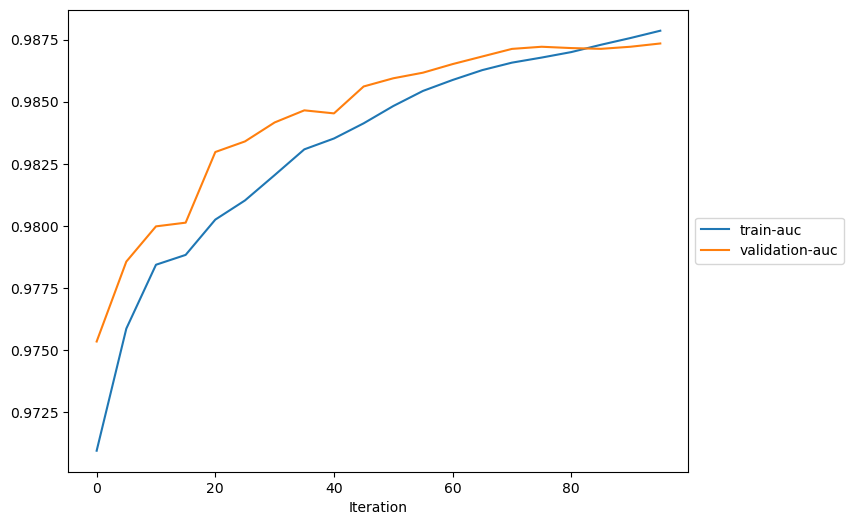

In [37]:
plot_collection(trial, "metrics")

In [38]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(trial, "feature_importance", regex=f"feature_importance/{importance_type}/.*")

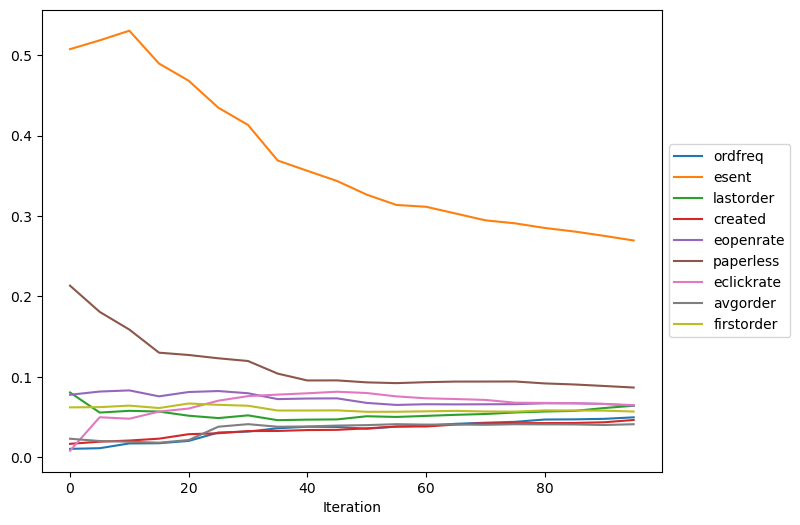

In [39]:
plot_feature_importance(trial, importance_type="cover")

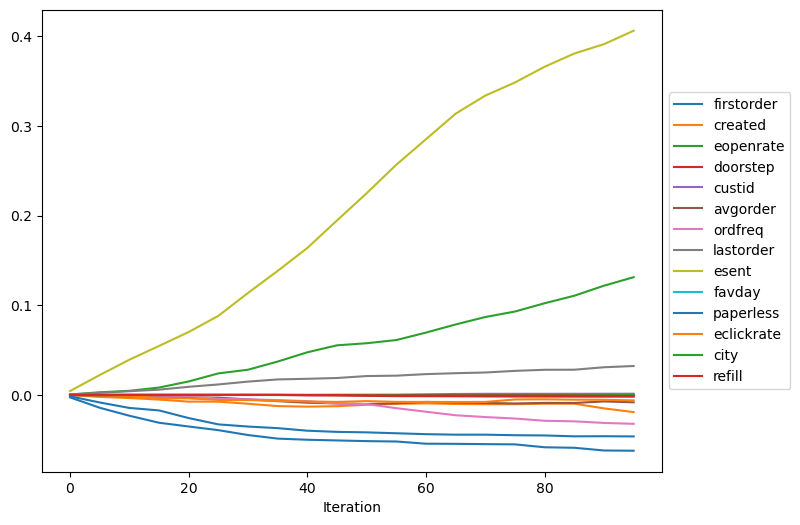

In [40]:
plot_collection(trial, "average_shap")

In [43]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.8 MB/s eta 0:00:00


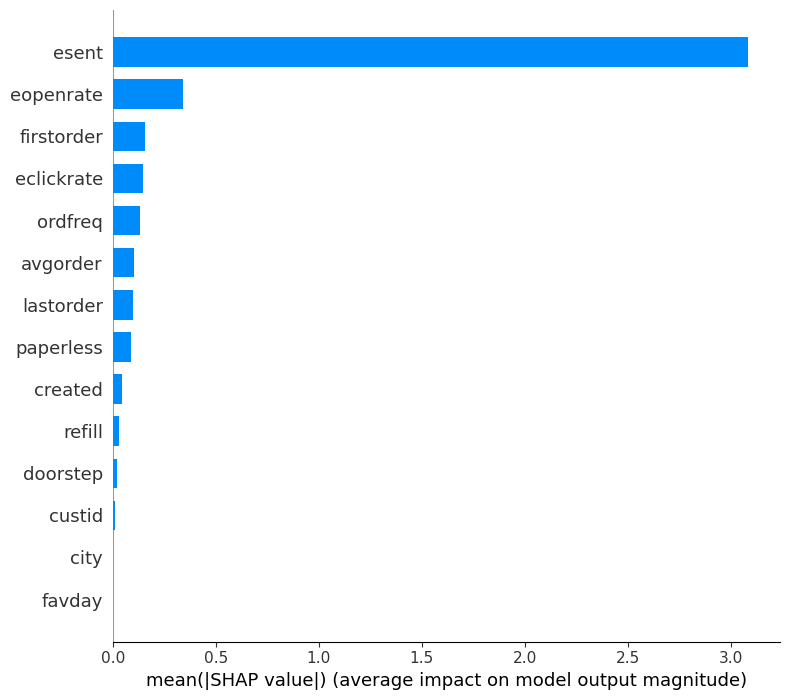

In [44]:
import shap

shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type="bar", feature_names=feature_names)

In [45]:
shap_base_value

2.1521585

In [46]:
train_shap = pd.DataFrame(train[:,1:],columns=feature_names)

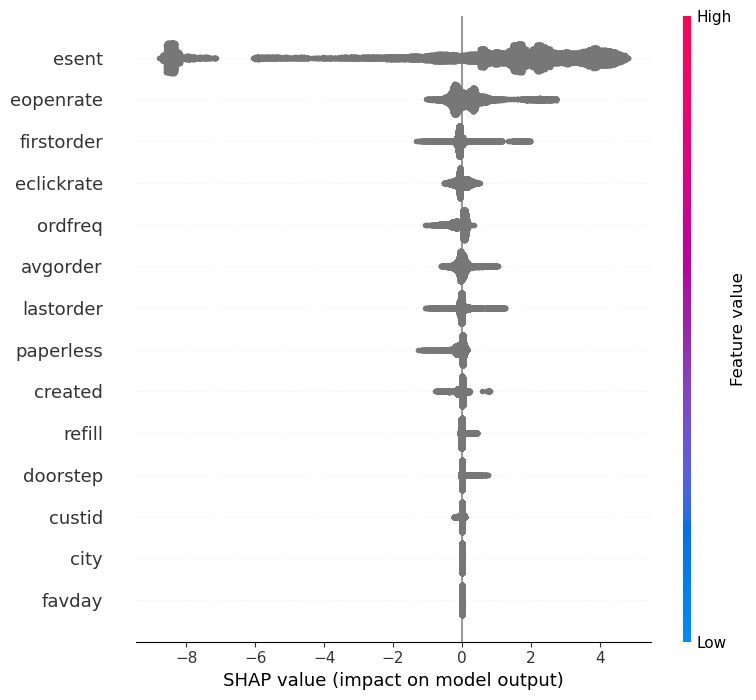

In [47]:
shap.summary_plot(shap_no_base, train_shap)

In [48]:
shap.initjs()

In [52]:
shap.force_plot(
    shap_base_value,
    shap_no_base[100, :],
    train_shap.iloc[100, :].astype(str),
    link="logit",
    matplotlib=False,
)

In [53]:
N_ROWS = shap_no_base.shape[0]
N_SAMPLES = min(100, N_ROWS)
sampled_indices = np.random.randint(N_ROWS, size=N_SAMPLES)

In [55]:
shap.force_plot(
    shap_base_value,
    shap_no_base[sampled_indices, :],
    train_shap.iloc[sampled_indices, :].astype(str),
    link="logit",
)